# 1- Data Acquisition

We are going to use a dataset that is already collected.

In [51]:
import pandas as pd
import json
from glob import glob
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [52]:


csv = pd.read_csv("/kaggle/input/dataset1/hack_train.csv")
csvFull = csv.rename(columns={'text': 'answers', "label" : "is_human"})
csv = csvFull.drop(columns="src")
answers_df = csv
# Checking the len
answers_df = answers_df.explode('answers', ignore_index=True)
answers_df = answers_df.dropna(subset=['answers'], ignore_index=True)

answers_df

,answers,is_human
0,Little disclaimer: this deals with US laws and...,1
1,"Read: Mentally Retarded Downs. See, we've got ...",1
2,"If any of you frequent rbadhistory, there is a...",1
3,"I believe in a flat tax system, where everyone...",1
4,"Edit: Ok guy's, my views have been changed on ...",1
...,...,...
56814,We consider the recovery of a source term f (x...,1
56815,"Self-supervised learning (SlfSL), aiming at le...",1
56816,Recurrent neural networks (RNNs) have achieved...,1
56817,Deep reinforcement learning (DRL) is a booming...,1


#  Setup the dataFrame for the predictive models

In [53]:
answers_df.head()

,answers,is_human
0,Little disclaimer: this deals with US laws and...,1
1,"Read: Mentally Retarded Downs. See, we've got ...",1
2,"If any of you frequent rbadhistory, there is a...",1
3,"I believe in a flat tax system, where everyone...",1
4,"Edit: Ok guy's, my views have been changed on ...",1


# 2. Exploring the data

Whenever we start working with a new dataset, and before we move on to making design decisions and creating a model, we have to get to know our data. Let’s answer some questions regarding our dataset:

**What does human_answers or chatgpt_answers looks like?**

In [54]:
#Human

human_answers_df = answers_df[answers_df['is_human'] == 1]
first_human_answer = human_answers_df.iloc[0]['answers']
print(first_human_answer)


Little disclaimer: this deals with US laws and procedures so I apologize if anyone outside the US isn't able to contribute, except to tell me how great it is having this in their own country. Last Sunday John Oliver's show dealt with this subject and chastised the US for being only one of two developed countries in the world without maternity leave that is paid for by the taxpayers. Here is a link to watch it if you haven't seen it yet: Here is the gist of my viewpoint: In the US, when a person is terminated from a job, heshe is entitled to unemployment benefits for up to 99 weeks or until they are employed again. Workers and companies pay into this and, while many people end up taking more than they give, it is the system we have and it seems to work for the majority of people here. When a person leaves a job VOLUNTARILY, however, they are not entitled to unemployment benefits. If you quit a job to go to another job this is fine. If you are quitting to go'find' yourself in Australia f

In [55]:
#Chatgpt

chatgpt_answers_df = answers_df[answers_df['is_human'] == 0]
first_chatgpt_answer = chatgpt_answers_df.iloc[0]['answers']
print(first_chatgpt_answer)

Little disclaimer: this deals with US laws and procedures so I apologize if anyone outside the US isn't able to contribute, except to tell me how great it is having this blog is now a book


**How long are the responses? from humans? from chatgpt?**

/tmp/ipykernel_104/4104485100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_answers_df['responses_length'] = human_answers_df.answers.apply(len)


Mean responses length:  1172.9371281444626
Min overview length:  24
Max overview length:  63723


<Axes: ylabel='Frequency'>

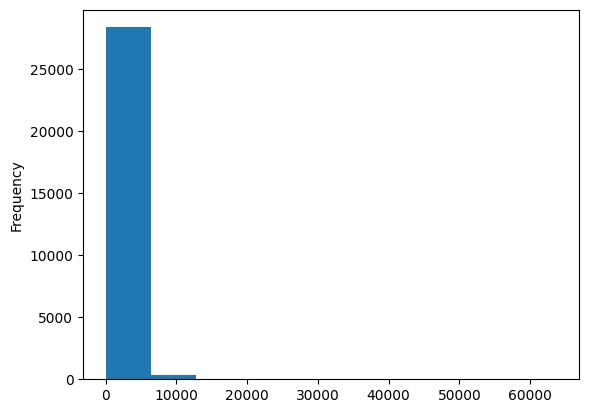

In [56]:
#Human 

human_answers_df['responses_length'] = human_answers_df.answers.apply(len)
print("Mean responses length: ", human_answers_df['responses_length'].mean())
print("Min overview length: ", human_answers_df['responses_length'].min())
print("Max overview length: ", human_answers_df['responses_length'].max())
human_answers_df.responses_length.plot.hist()

/tmp/ipykernel_104/2606865523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatgpt_answers_df['responses_length'] = chatgpt_answers_df.answers.apply(len)


Mean responses length:  1288.4463993161905
Min overview length:  28
Max overview length:  8033


<Axes: ylabel='Frequency'>

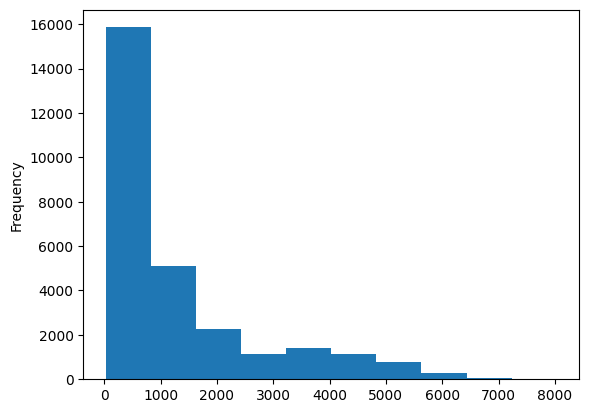

In [57]:
#Chatgpt

chatgpt_answers_df['responses_length'] = chatgpt_answers_df.answers.apply(len)
print("Mean responses length: ", chatgpt_answers_df['responses_length'].mean())
print("Min overview length: ", chatgpt_answers_df['responses_length'].min())
print("Max overview length: ", chatgpt_answers_df['responses_length'].max())
chatgpt_answers_df.responses_length.plot.hist()

**A word cloud to see what are the most common words in the responses**

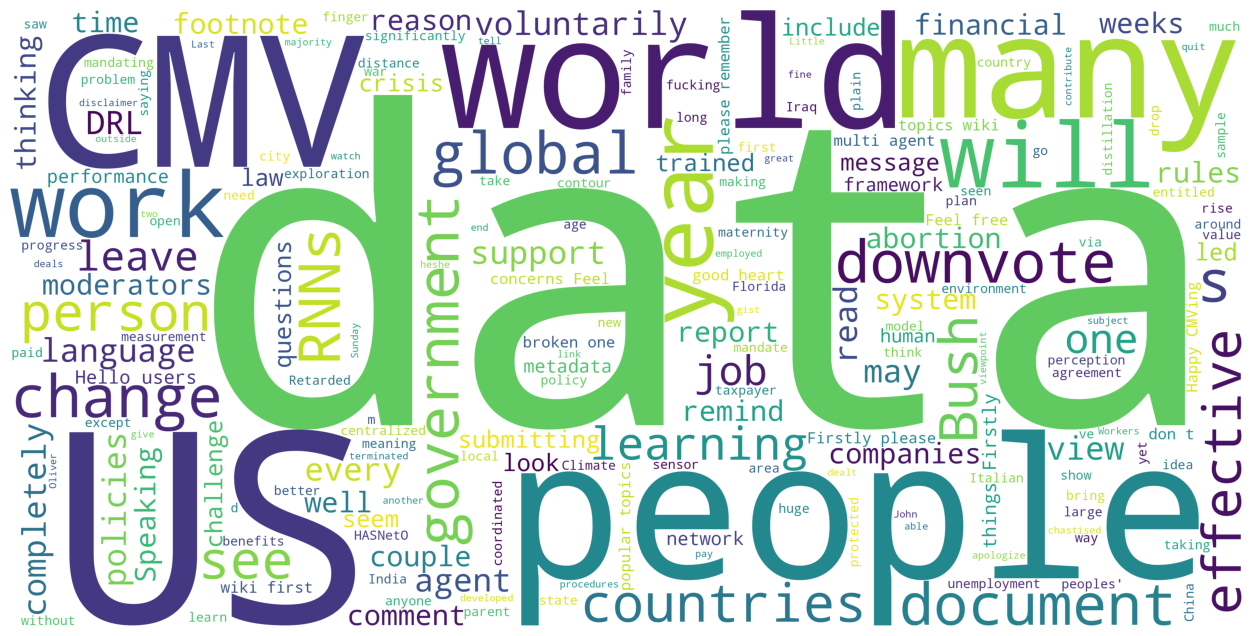

In [58]:
#Human

stopwords = set(STOPWORDS)
humans_words_text = human_answers_df['answers'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(humans_words_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


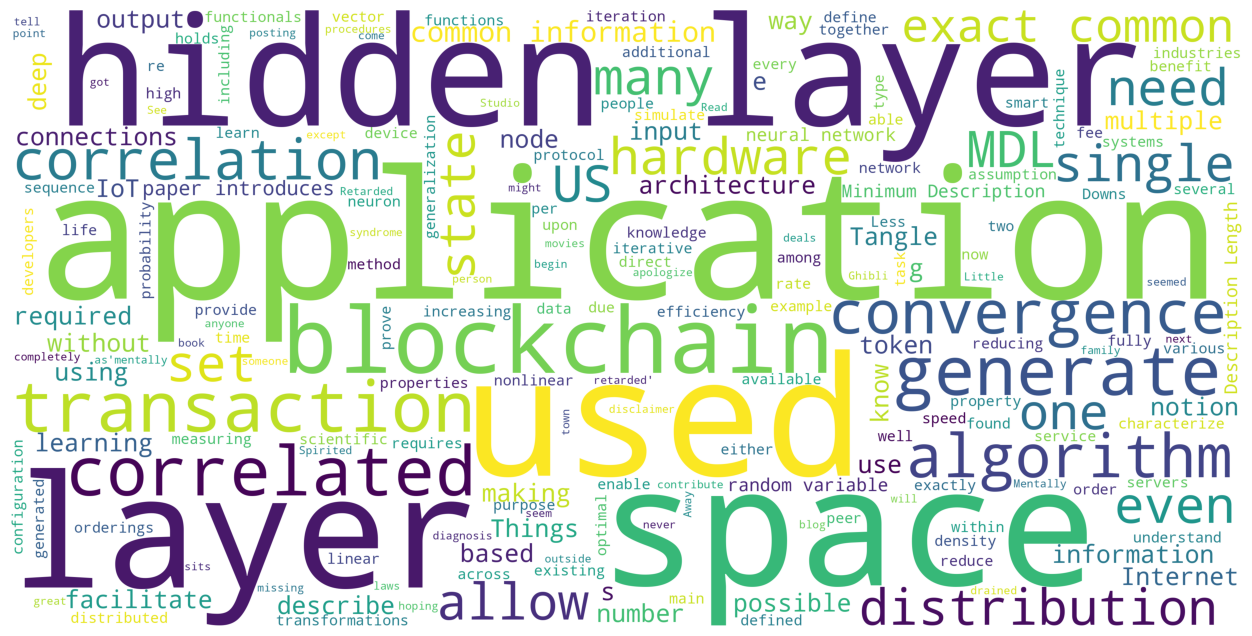

In [59]:
#Chatgpt

stopwords = set(STOPWORDS)
chatgpt_words_text = chatgpt_answers_df['answers'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(chatgpt_words_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [60]:
X = answers_df['answers']
y = answers_df['is_human']

#Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

#Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

In [61]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

max_len = 100  # Choisissez la longueur maximale souhaitée
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)


**Construction du Modèle de Réseau de Neurones**

In [158]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 64, input_length=max_len),
    tf.keras.layers.Flatten(),
    Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [159]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Architecture du modèle :")
model.summary()

Architecture du modèle :


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training

In [160]:
# Entraînement du modèle
print("\nTraining start...")
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_val_pad, y_val))


Training start...
Epoch 1/5
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2:17:11 6s/step - accuracy: 0.3750 - loss: 0.69 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4873 - loss: 0.6942   ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4894 - loss: 0.69 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4920 - loss: 0.69 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4932 - loss: 0.69 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4940 - loss: 0.69 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4952 - loss: 0.69 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4969 - loss: 0.69 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4984 - loss: 0.69 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4998 - loss: 0.69 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5011 - loss: 0.69 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5024 - loss: 0.69 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5040 - loss: 0.68 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5055 - loss: 0.68 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy

W0000 00:00:1713968662.024587     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1421/1421 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8943 - loss: 0.28 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8972 - loss: 0.27 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8994 - loss: 0.26 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9016 - loss: 0.25 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9038 - loss: 0.25 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9056 - loss: 0.24 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9068 - loss: 0.24 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9079 - loss: 0.24 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9087 - loss: 0.24 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9093 - loss: 0.23 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9100 - loss: 0.23 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9106 - loss: 0.23 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9111 - loss: 0.23 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9116 - loss: 0.23 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9120 - loss: 0.23 ━━━━━━━━━━━━━━━

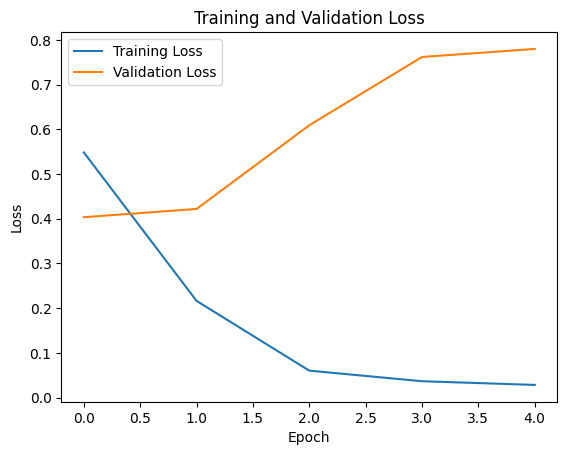

In [161]:
# Affichage de l'historique de la perte
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

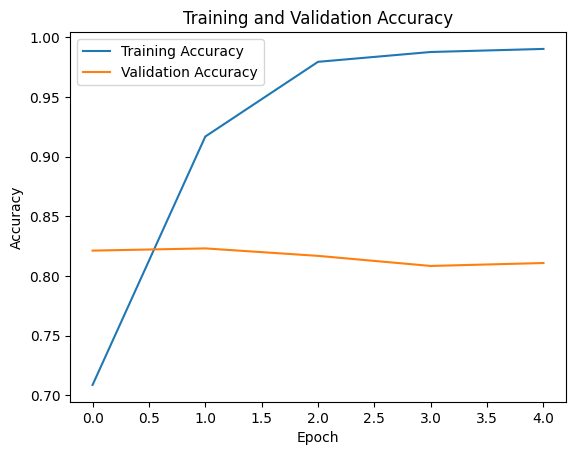

In [162]:
# Affichage de l'historique de la précision
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [163]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6875 - loss: 1.011 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7850 - loss: 0.879 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7907 - loss: 0.86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7947 - loss: 0.84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7974 - loss: 0.83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8003 - loss: 0.82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8024 - loss: 0.81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8036 - loss: 0.81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8048 - loss: 0.80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8056 - loss: 0.80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8065 - loss: 0.80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8073 - loss: 0.79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8081 - loss: 0.79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8085 - loss: 0.79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8087 - loss: 0.79 ━━━━━━━━━━━━━━

In [136]:
predictions = model.predict(X_test_pad)
predicted_classes = (predictions > 0.5).astype(int)

356/356 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Text(0.5, 1.0, 'Matrice de confusion')

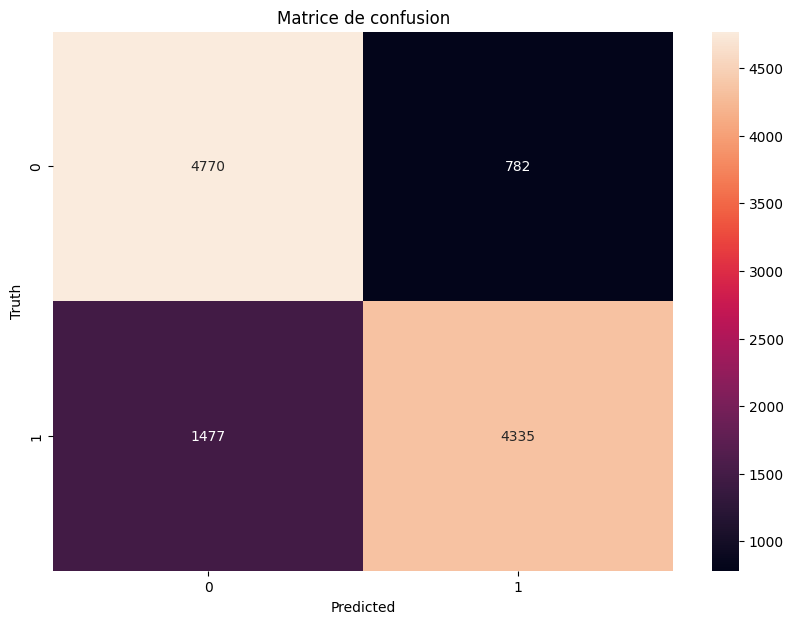

In [164]:
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Matrice de confusion')

In [165]:
print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      5552
           1       0.85      0.75      0.79      5812

    accuracy                           0.80     11364
   macro avg       0.81      0.80      0.80     11364
weighted avg       0.81      0.80      0.80     11364



In [166]:
import colorama
from colorama import Fore, Style
from tensorflow.keras.preprocessing.sequence import pad_sequences

colorama.init(autoreset=True)

test_answers = [
    ('Who is the strongest between Itachi and Jiraiya?', 
    'Itachi is stronger by far and I can prove it.', 
    """It's hard to determine conclusively who is stronger between Itachi and Jiraiya.
     Both have unique strengths and weaknesses. Itachi excels in Sharingan and genjutsu mastery,
      while Jiraiya is a proficient user of ninjutsu and senjutsu. Their relative power depends on various factors, 
      including their respective skills, combat strategies, and physical/mental condition during battle."""
    )
]

def human_or_gpt(n):
    label = "HUMAN" if n[0][0] > 0.5 else 'GPT'
    return Fore.BLUE + label + Style.RESET_ALL

def testsuite(model, tests, tokenizer, max_len):
    for test in tests:
        (qst, human, gpt) = test
        print(f"Question: {qst}")
        
        # Tokenization and padding
        human_seq = tokenizer.texts_to_sequences([human])
        human_pad = pad_sequences(human_seq, maxlen=max_len)
        gpt_seq = tokenizer.texts_to_sequences([gpt])
        gpt_pad = pad_sequences(gpt_seq, maxlen=max_len)
        
        # Prediction
        human_pred = model.predict(human_pad)
        gpt_pred = model.predict(gpt_pad)
        
        print(f"Human Answer: [{human[:25]}] the model thinks it was written by a {human_or_gpt(human_pred)}")
        print(f"GPT Answer: [{gpt[:25]}] the model thinks it was written by a {human_or_gpt(gpt_pred)}")

# Exemple d'utilisation de la fonction avec le tokenizer et max_len appropriés
testsuite(model, test_answers, tokenizer, max_len) 



Question: Who is the strongest between Itachi and Jiraiya?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Human Answer: [Itachi is stronger by far] the model thinks it was written by a HUMAN
GPT Answer: [It's hard to determine co] the model thinks it was written by a GPT
